In this notebook, I will calculate total heterozygosity in the primatediversity data lifted to human.

The lessons learned here are used in notebook 2, as well as verify that the underlying windows are stable.

In [1]:
%run ../scripts/notebook_settings_lean.py

In [2]:
data_path = "/home/eriks/primatediversity/data/lifted_tables_human_coordinates_21_04_21/"
header_list = ["chr", "bp", "hg38", "monkey", "hg38_strand", "monkey_strand", "chrom", "b_p",
               "monkey_ref", "monkey_alt", "AC", "DP", "MQ", "FS", "QD", "SOR", "GQ", "ADFrac", "ADP",
               "f_monkey_ref", "f_monkey_alt"]
files = os.listdir(data_path)



In [3]:
data_test = pd.read_csv(data_path+"PD_0734.papAnu4_lift_hg38.maf.SNPs.refmatch.txt.gz",
                        compression="gzip", sep="\t", names=header_list)

In [4]:
max(data_test.bp)

248944964

In [5]:
len(data_test.loc[(data_test.GQ==99) & (data_test.ADFrac >= 0.9)])

677743

In [6]:
len(data_test.loc[(data_test.GQ==99) & (data_test.ADFrac < 0.7) & (data_test.ADFrac > 0.3)])

2278307

In [7]:
len(data_test.loc[(data_test.GQ==99) & (data_test.ADFrac < 1)])

2399559

[None]

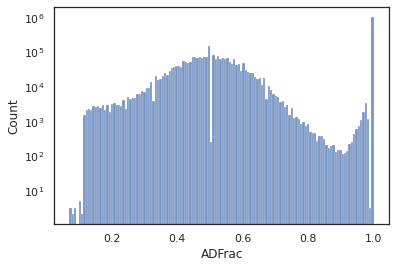

In [8]:
g = sns.histplot(data_test, x="ADFrac")
g.set(yscale="log")

[None]

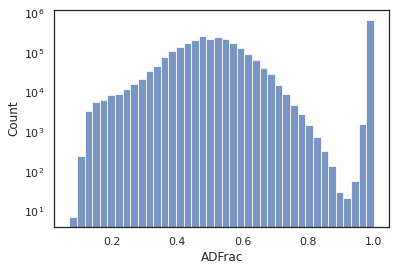

In [9]:
g = sns.histplot(data_test.loc[(data_test.GQ==99)], x="ADFrac", bins=40)
g.set(yscale="log")

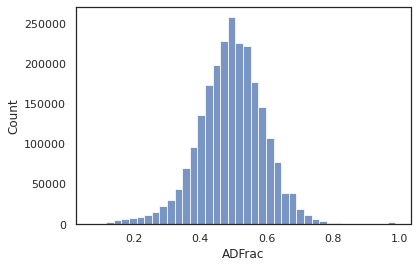

In [10]:
test_subset = data_test.loc[(data_test.GQ==99) & (data_test.ADFrac < 1)]
g = sns.histplot(test_subset, x="ADFrac", bins=40)

Reading the code as made from het_count in workflow_het_count

In [11]:
df_l = []
import glob
for f in glob.glob("../steps/het_stats/temp/*match.txt"):
    df_l.append(pd.read_csv(f))
het_df = pd.concat(df_l).reset_index()

In [12]:
# And saving the df
het_df.to_csv("../steps/het_stats/het_count.txt", index=False)

In [13]:
ref_df = het_df.loc[het_df.match_type == "refmatch"]
alt_df = het_df.loc[het_df.match_type == "altmatch"]
no_df = het_df.loc[het_df.match_type == "nomatch"]

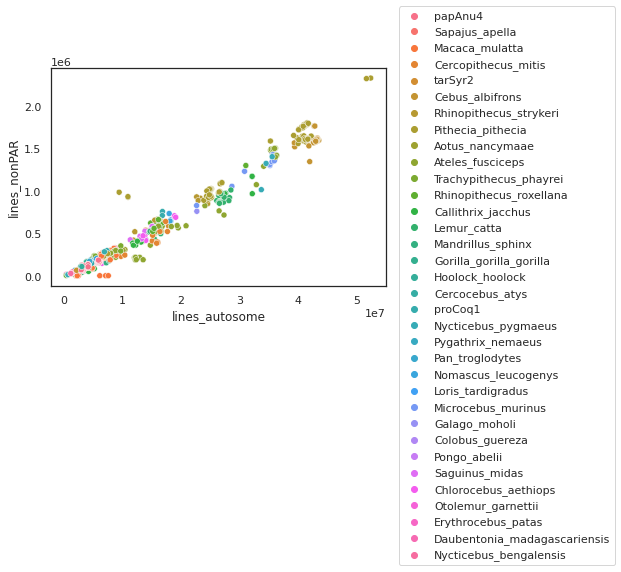

In [14]:
g = sns.scatterplot(data=ref_df, x="lines_autosome", y="lines_nonPAR", hue="species")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0))

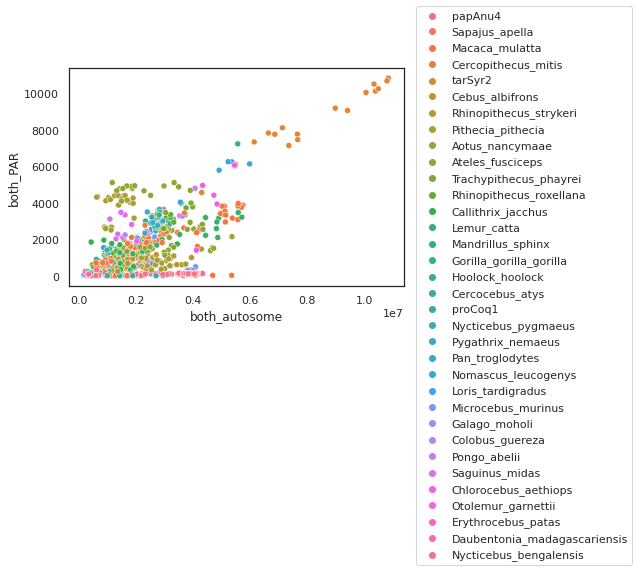

In [15]:
g = sns.scatterplot(data=ref_df, x="both_autosome", y="both_PAR", hue="species")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0))

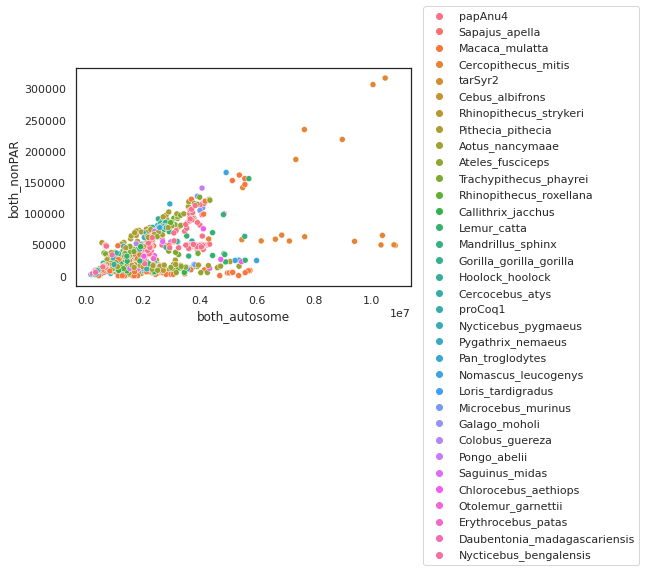

In [16]:
g = sns.scatterplot(data=ref_df, x="both_autosome", y="both_nonPAR", hue="species")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0))

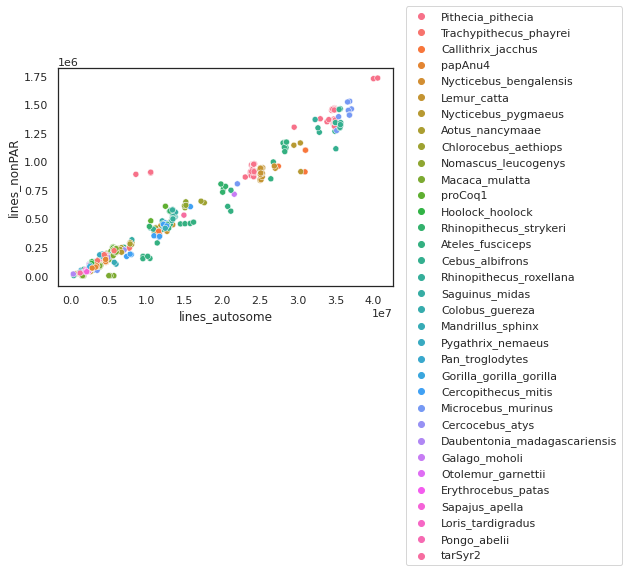

In [17]:
g = sns.scatterplot(data=alt_df, x="lines_autosome", y="lines_nonPAR", hue="species")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0))

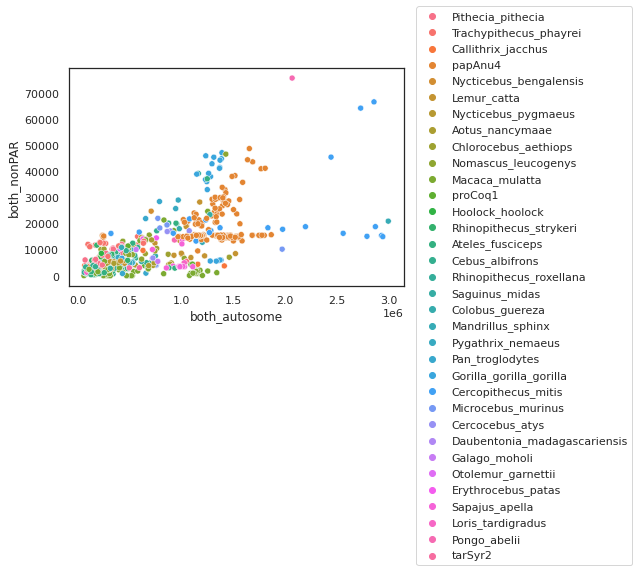

In [18]:
g = sns.scatterplot(data=alt_df, x="both_autosome", y="both_nonPAR", hue="species")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0))

This was without any filtering of individuals - time to find the males.

In [19]:
ref_df["a_X_ratio"] = (100/8)*ref_df.both_nonPAR/ref_df.both_autosome

/home/eriks/miniconda3/envs/primatediversity/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='both_autosome', ylabel='both_nonPAR'>

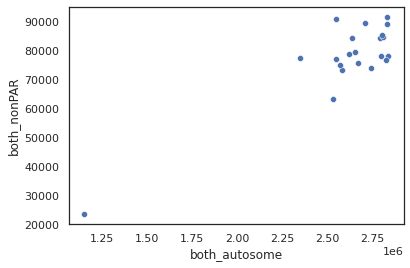

In [20]:
sns.scatterplot(data=ref_df.loc[ref_df.species == "Gorilla_gorilla_gorilla"], y="both_nonPAR", x="both_autosome")

<AxesSubplot:xlabel='both_autosome', ylabel='a_X_ratio'>

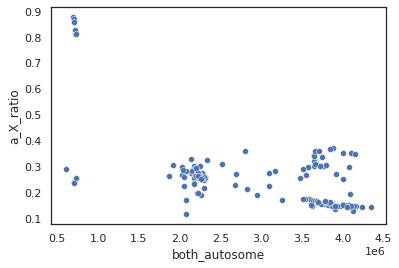

In [21]:
sns.scatterplot(data=ref_df.loc[ref_df.species == "papAnu4"], y="a_X_ratio", x="both_autosome")

This was not that obvious, so analysis to find males will now be stratified based on median het in 100kb windows.

In [22]:
#Settings
cutoff = 25

#Lists for dataframe
df_l = []
id_list = []
species_list = []
match_list = []
X_med_het, X_mean_het, X_upper_quart = [], [], []
X_10, X_25, aut_10, aut_25 = [], [], [], []
aut_med_het, aut_mean_het = [], []
import glob
glob_list = glob.glob("../steps/het_stats/temp/*window100000.txt")
for f in glob_list:
    het_df_window = pd.read_csv(f)
    id_list.append(het_df_window.PGDP_ID.values[0])
    if len(id_list) % 100 == 0:
        print((len(id_list)*100)//len(glob_list), "%")
    species_list.append(het_df_window.species.values[0])
    match_list.append(het_df_window.match_type.values[0])
    x_series = het_df_window.loc[(het_df_window.chr == "chrX") &
                                 (het_df_window.lines > cutoff)].both_pass
    aut_series = het_df_window.loc[(het_df_window.chr != "chrY") &
                                   (het_df_window.chr != "chrX") &
                                   (het_df_window.lines > cutoff)].both_pass
    if len(x_series) < 5:
        X_med_het.append(0)
        X_mean_het.append(0)
        X_upper_quart.append(0)
        X_10.append(0)
        X_25.append(0)
    else:
        X_med_het.append(x_series.median())
        X_mean_het.append((x_series.mean()))
        X_upper_quart.append(np.quantile(x_series, 0.75))
        X_10.append(np.quantile(x_series, 0.1))
        X_25.append(np.quantile(x_series, 0.25))
    aut_med_het.append((aut_series.median()))
    aut_mean_het.append((aut_series.mean()))
    aut_10.append(np.quantile(aut_series, 0.1))
    aut_25.append(np.quantile(aut_series, 0.25))

het_df_window = pd.DataFrame({"PGDP_ID": id_list, "species": species_list, "match_type": match_list,
                             "X_median": X_med_het, "X_mean": X_mean_het, "X_per_75": X_upper_quart,
                              "aut_median": aut_med_het, "aut_mean": aut_mean_het,
                              "X_per_10": X_10, "X_per_25": X_25, "aut_per_10": aut_10, "aut_per_25": aut_25})

4 %
9 %
14 %
18 %
23 %
28 %
33 %
37 %
42 %
47 %
52 %
56 %
61 %
66 %
71 %
75 %
80 %
85 %
90 %
94 %
99 %


In [23]:
het_df_window["X_auto_med_ratio"] = het_df_window.X_median/het_df_window.aut_median
het_df_window["X_quart_mean_ratio"] = het_df_window.X_per_75/het_df_window.X_mean
het_df_window["aut_med_mean_ratio"] = het_df_window.aut_median/het_df_window.aut_mean
het_df_window["X_med_mean_ratio"] = het_df_window.X_median/het_df_window.X_mean
het_df_window = het_df_window.fillna(0)
het_df_window.loc[het_df_window.match_type == "refmatch"]

,PGDP_ID,species,match_type,X_median,X_mean,X_per_75,aut_median,aut_mean,X_per_10,X_per_25,aut_per_10,aut_per_25,X_auto_med_ratio,X_quart_mean_ratio,aut_med_mean_ratio,X_med_mean_ratio
8,PD_0356,Cebus_albifrons,refmatch,3.0,11.404040,10.0,15.0,40.852173,0.0,1.0,1.0,2.0,0.200000,0.876882,0.367178,0.263065
9,PD_0095,Cercopithecus_mitis,refmatch,0.0,40.907661,5.0,410.0,395.807301,0.0,0.0,191.0,304.0,0.000000,0.122226,1.035858,0.000000
13,PD_0203,papAnu4,refmatch,36.0,41.865900,56.0,78.0,86.197415,6.0,23.0,10.6,43.0,0.461538,1.337604,0.904900,0.859888
15,PD_0318,Pithecia_pithecia,refmatch,1.0,21.712845,6.0,17.0,39.531172,0.0,0.0,0.0,3.0,0.058824,0.276334,0.430040,0.046056
19,PD_0531,Loris_tardigradus,refmatch,0.0,2.299691,0.0,3.0,9.452240,0.0,0.0,0.0,0.0,0.000000,0.000000,0.317385,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,PD_0621,Lemur_catta,refmatch,0.0,12.612813,4.0,74.0,82.332649,0.0,0.0,15.0,38.0,0.000000,0.317138,0.898793,0.000000
2102,PD_0774,papAnu4,refmatch,42.0,53.742414,92.0,139.0,135.958111,0.0,1.0,24.0,85.0,0.302158,1.711870,1.022374,0.781506
2106,PD_0385,Sapajus_apella,refmatch,0.0,7.588022,1.0,51.0,61.244609,0.0,0.0,6.0,18.0,0.000000,0.131787,0.832726,0.000000
2107,PD_0845,Nycticebus_bengalensis,refmatch,38.0,40.793539,52.0,45.0,50.891833,19.0,27.0,4.0,23.0,0.844444,1.274712,0.884228,0.931520


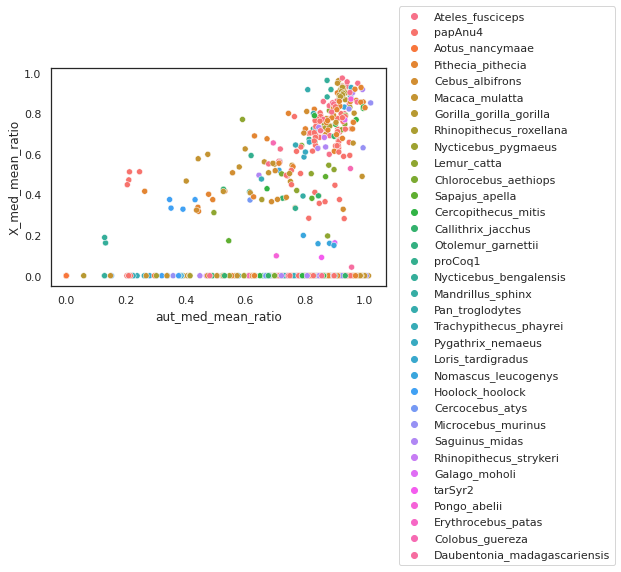

In [24]:
alt_df = het_df_window.loc[(het_df_window.match_type == "altmatch")]
g = sns.scatterplot(data=alt_df, y = "X_med_mean_ratio", x="aut_med_mean_ratio", hue="species")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0))

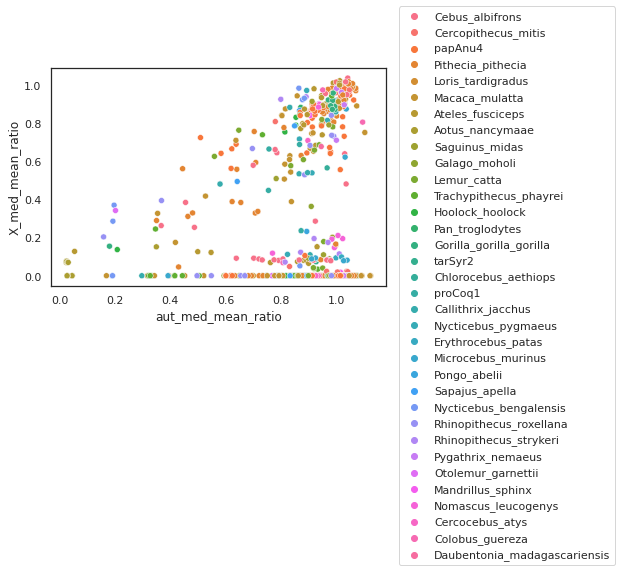

In [25]:
alt_df = het_df_window.loc[(het_df_window.match_type == "refmatch")]
g = sns.scatterplot(data=alt_df, y = "X_med_mean_ratio", x="aut_med_mean_ratio", hue="species")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0))

In [26]:
sex_map = {}
for i, row in alt_df.iterrows():
    if row.X_med_mean_ratio <= 0.4*row.aut_med_mean_ratio:
        sex_map[row.PGDP_ID] = "M"
    else:
        sex_map[row.PGDP_ID] = "F"

In [27]:
#het_df_window["sex"] = het_df_window.PGDP_ID.map(sex_map)
#het_df_window.to_csv("../steps/het_stats/het_overview_100kb_windows.txt", index=False)
het_df_window = pd.read_csv("../steps/het_stats/het_overview_100kb_windows.txt")

In [28]:
len(het_df_window.loc[(het_df_window.sex == "F") & (het_df_window.match_type == "refmatch")])

291

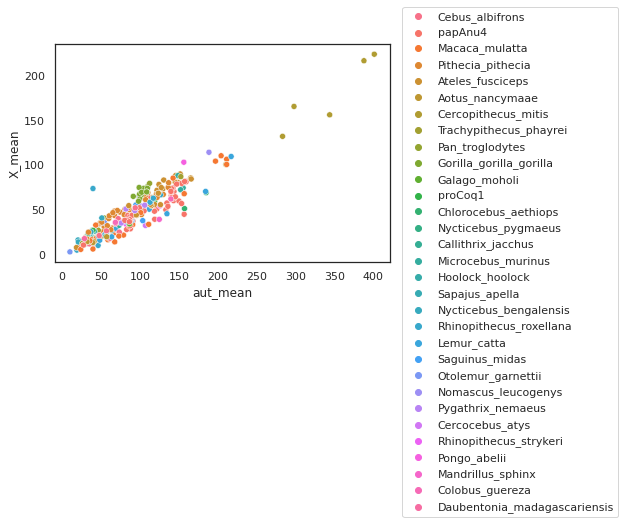

In [29]:
alt_df = het_df_window.loc[(het_df_window.sex == "F") & (het_df_window.match_type == "refmatch")]
g = sns.scatterplot(data=alt_df, x = "aut_mean", y="X_mean", hue="species")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0))

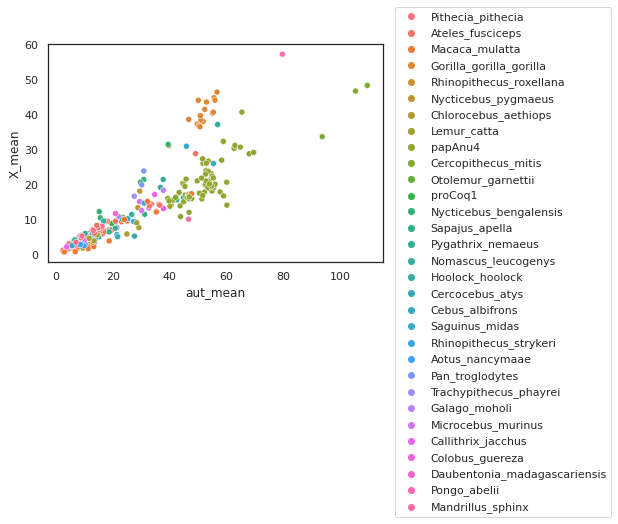

In [30]:
alt_df = het_df_window.loc[(het_df_window.sex == "F") & (het_df_window.match_type == "altmatch")]
g = sns.scatterplot(data=alt_df, x = "aut_mean", y="X_mean", hue="species")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0))

Creating a metadata file based on PGDP_md and sex_via_coverage

In [31]:
metadata_path ="/home/eriks/primatediversity/data/PGDP_16_7_2020/metadata/"
meta_data_samples = pd.read_excel(metadata_path+"PGDP_md.16.7.2020.xlsx")
sex_cov = pd.read_csv(metadata_path+"sex_via_coverage_Lukas.csv")

In [32]:
meta_data_samples

,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID
0,PD_0001,Cheracebus,lugens,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.fasta
1,PD_0002,Callibella,humilis,FAIL,PASS,Callithrix_jacchus,Callithrix_jacchus.fasta
2,PD_0003,Cacajao,hosomi,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa
3,PD_0004,Ateles,belzebuth,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa
4,PD_0005,Alouatta,seniculus,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa
...,...,...,...,...,...,...,...
695,PD_0843,Trachypithecus,vetulus,PASS,PASS,Trachypithecus_phayrei,Trachypithecus_phayrei.fasta
696,PD_0844,Leontopithecus,chrysomelas,PASS,PASS,Callithrix_jacchus,Callithrix_jacchus.fasta
697,PD_0845,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta
698,PD_0846,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta


In [33]:
meta_data_samples["PGDP_ID"] = meta_data_samples["PDGP_ID"]

In [34]:
len(meta_data_samples), len(het_df_window)/3
len(meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(het_df_window.PGDP_ID)])

678

In [35]:
in_all = sex_cov.loc[(sex_cov.PGDP_ID.isin(meta_data_samples.PGDP_ID)) & (sex_cov.PGDP_ID.isin(het_df_window.PGDP_ID))].reset_index()
# There is 553 individuals using this
in_all["sex"] = ["M" if x <= 0.7 else "F" for x in in_all.X_over_autosome_ratio]

<AxesSubplot:xlabel='X_over_autosome_ratio', ylabel='Count'>

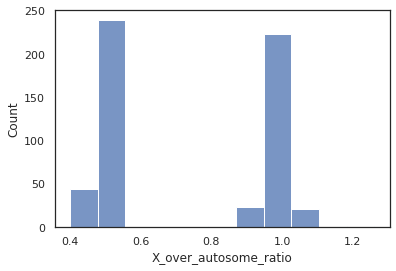

In [36]:
sns.histplot(in_all.X_over_autosome_ratio)

In [37]:
(sex_cov.X_over_autosome_ratio < 0.7).sum()

329

In [38]:
meta_data_samples_subset = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(in_all.PGDP_ID)].reset_index()
meta_data_samples_subset["sex"] = in_all.sex

In [39]:
(in_all.sex == "F").sum()

270

In [40]:
meta_data_samples_subset

,index,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,sex
0,0,PD_0001,Cheracebus,lugens,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.fasta,PD_0001,F
1,2,PD_0003,Cacajao,hosomi,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa,PD_0003,M
2,3,PD_0004,Ateles,belzebuth,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa,PD_0004,F
3,4,PD_0005,Alouatta,seniculus,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa,PD_0005,M
4,5,PD_0006,Chiropotes,israelita,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa,PD_0006,F
...,...,...,...,...,...,...,...,...,...,...
548,695,PD_0843,Trachypithecus,vetulus,PASS,PASS,Trachypithecus_phayrei,Trachypithecus_phayrei.fasta,PD_0843,F
549,696,PD_0844,Leontopithecus,chrysomelas,PASS,PASS,Callithrix_jacchus,Callithrix_jacchus.fasta,PD_0844,M
550,697,PD_0845,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0845,F
551,698,PD_0846,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0846,F


In [41]:
meta_data_samples_subset

,index,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,sex
0,0,PD_0001,Cheracebus,lugens,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.fasta,PD_0001,F
1,2,PD_0003,Cacajao,hosomi,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa,PD_0003,M
2,3,PD_0004,Ateles,belzebuth,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa,PD_0004,F
3,4,PD_0005,Alouatta,seniculus,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa,PD_0005,M
4,5,PD_0006,Chiropotes,israelita,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa,PD_0006,F
...,...,...,...,...,...,...,...,...,...,...
548,695,PD_0843,Trachypithecus,vetulus,PASS,PASS,Trachypithecus_phayrei,Trachypithecus_phayrei.fasta,PD_0843,F
549,696,PD_0844,Leontopithecus,chrysomelas,PASS,PASS,Callithrix_jacchus,Callithrix_jacchus.fasta,PD_0844,M
550,697,PD_0845,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0845,F
551,698,PD_0846,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta,PD_0846,F


In [42]:
het_df_window_sorted = het_df_window.sort_values(by=["PGDP_ID"])
meta_data_het_stats = het_df_window_sorted.merge(meta_data_samples_subset)

In [43]:
len(meta_data_samples_subset.loc[meta_data_samples_subset.PGDP_ID.isin(het_df_window_sorted.PGDP_ID)])

553

In [44]:
len(meta_data_het_stats.PGDP_ID.unique())

520

In [45]:
ref_female = meta_data_het_stats.loc[(meta_data_het_stats.sex == "F") & (meta_data_het_stats.match_type == "refmatch")]

In [46]:
ref_female

,PGDP_ID,species,match_type,X_median,X_mean,X_per_75,aut_median,aut_mean,X_per_10,X_per_25,...,X_med_mean_ratio,sex,index,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID
2,PD_0001,Pithecia_pithecia,refmatch,8.0,20.807537,28.0,34.0,51.924952,1.0,2.0,...,0.384476,F,0,PD_0001,Cheracebus,lugens,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.fasta
6,PD_0004,Ateles_fusciceps,refmatch,75.0,80.835954,126.5,150.0,145.273046,1.0,24.0,...,0.927805,F,3,PD_0004,Ateles,belzebuth,PASS,PASS,Ateles_geoffroyi,Ateles_geoffroyi.bgi.fa
12,PD_0006,Pithecia_pithecia,refmatch,39.0,48.348525,82.0,83.0,83.781233,1.0,4.0,...,0.806643,F,5,PD_0006,Chiropotes,israelita,PASS,PASS,Pithecia_pithecia,Pithecia_pithecia.bgi.fa
17,PD_0007,Cebus_albifrons,refmatch,33.0,34.516345,48.0,66.0,68.728265,2.0,16.0,...,0.956069,F,6,PD_0007,Cebus,olivaceus,PASS,PASS,Cebus_albifrons,Cebus_albifrons.bgi.fa
18,PD_0008,Aotus_nancymaae,refmatch,3.0,19.784784,18.0,20.0,57.187844,0.0,1.0,...,0.151632,F,7,PD_0008,Aotus,trivirgatus,PASS,PASS,Aotus_nancymaae,Aotus_nancymaae.fasta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,PD_0838,Macaca_mulatta,refmatch,76.0,85.269777,128.0,153.0,142.546105,4.0,37.0,...,0.891289,F,690,PD_0838,Macaca,fascicularis,PASS,WARN,Macaca_mulatta,Macaca_mulatta.fasta
1544,PD_0842,Nycticebus_bengalensis,refmatch,25.0,27.061364,38.0,34.0,38.741670,1.0,9.0,...,0.923826,F,694,PD_0842,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta
1545,PD_0843,Trachypithecus_phayrei,refmatch,82.0,86.906774,120.0,150.0,152.569357,12.0,44.0,...,0.943540,F,695,PD_0843,Trachypithecus,vetulus,PASS,PASS,Trachypithecus_phayrei,Trachypithecus_phayrei.fasta
1553,PD_0845,Nycticebus_bengalensis,refmatch,38.0,40.793539,52.0,45.0,50.891833,19.0,27.0,...,0.931520,F,697,PD_0845,Nycticebus,bengalensis,PASS,PASS,Nycticebus_pygmaeus,Nycticebus_pygmaeus.fasta


In [47]:
ref_female["X_auto_ratio"] = ref_female.X_mean/ref_female.aut_mean

/home/eriks/miniconda3/envs/primatediversity/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
ref_female.loc[ref_female.GENUS == "P"]

,PGDP_ID,species,match_type,X_median,X_mean,X_per_75,aut_median,aut_mean,X_per_10,X_per_25,...,sex,index,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,X_auto_ratio


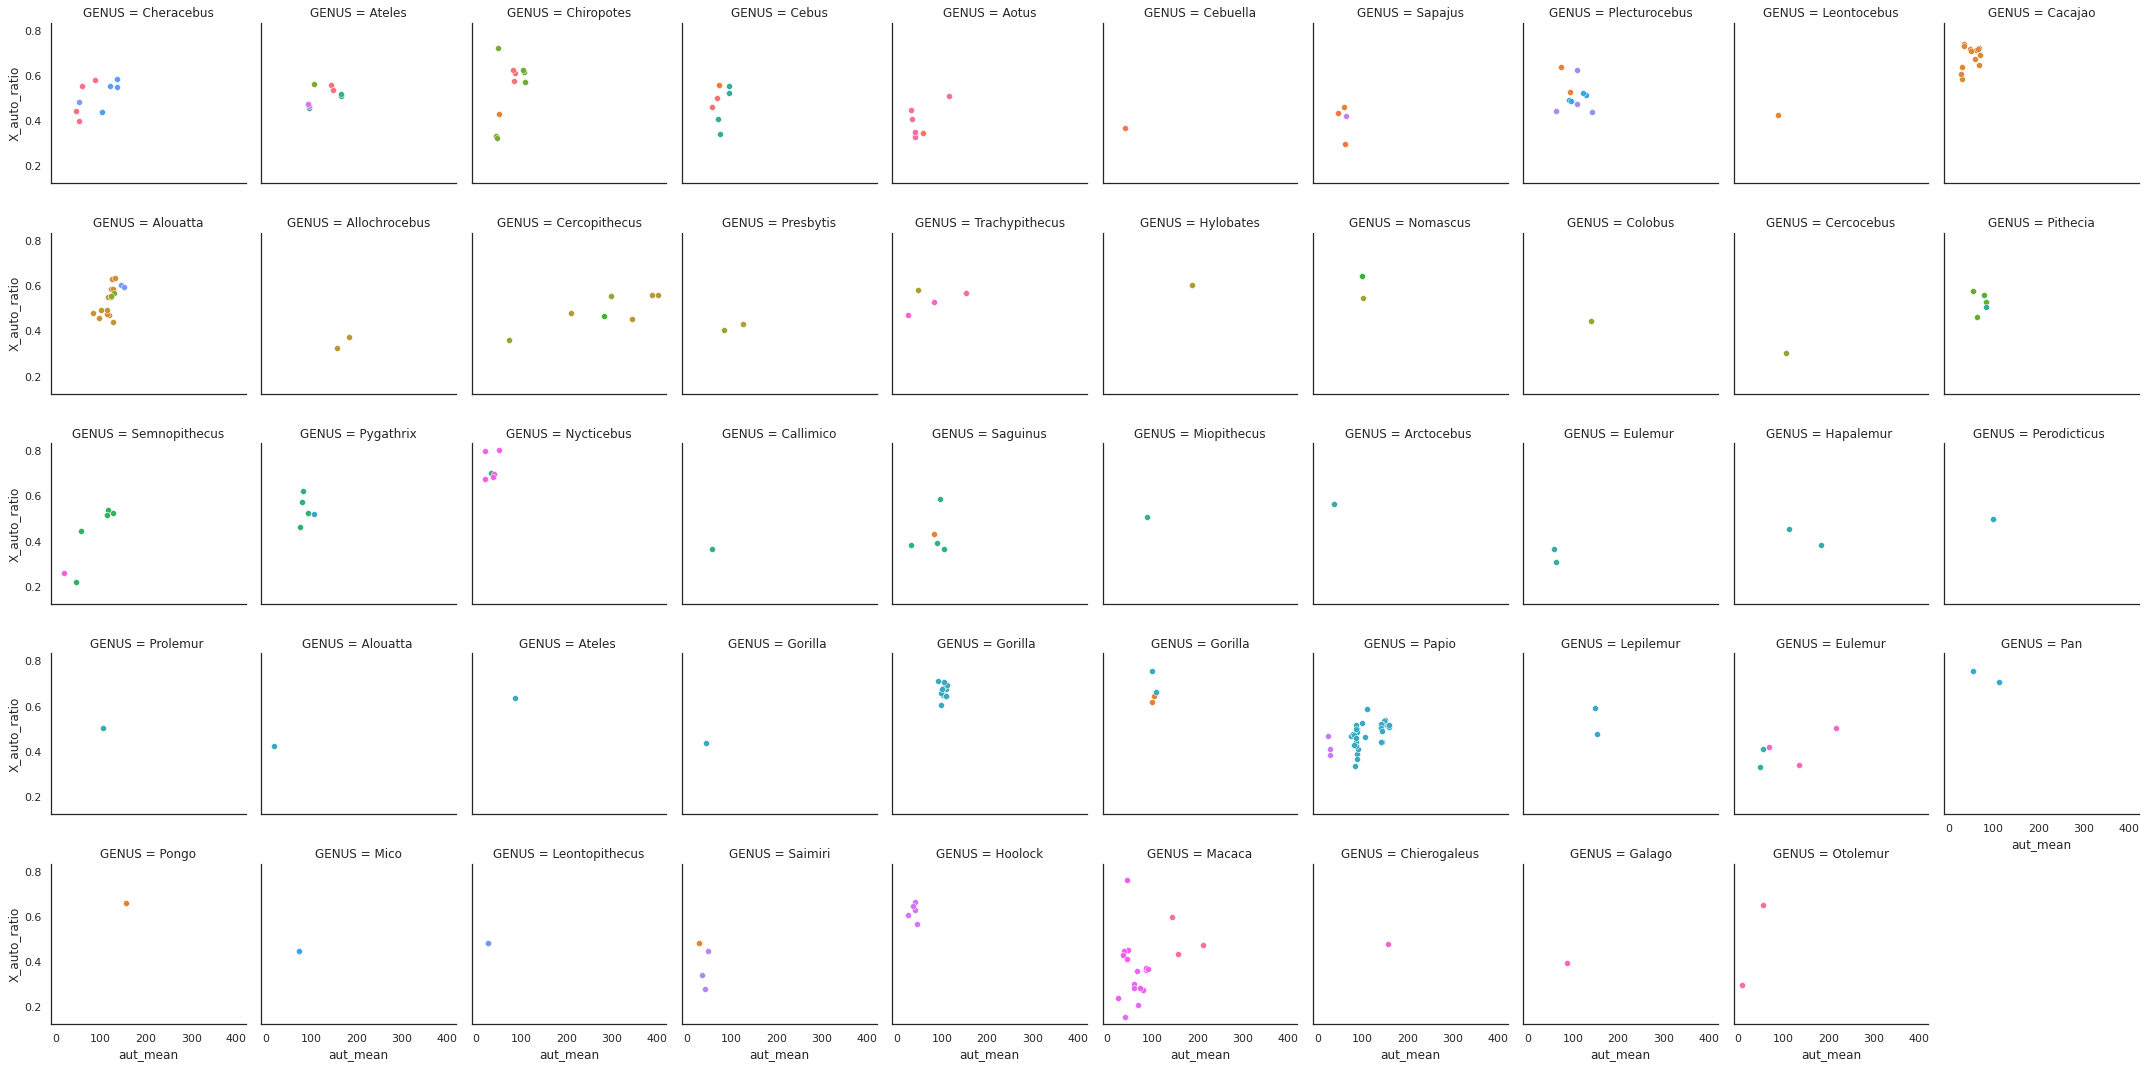

In [49]:
g = sns.FacetGrid(ref_female, hue="SPECIES", col="GENUS", col_wrap = 10)
g.map(sns.scatterplot, "aut_mean", "X_auto_ratio")

Final way of doing it:
1Mb windows, and I optimize to make it fit Lukas´s predictions.

In [50]:
df_l = []
id_list = []
species_list = []
match_list = []
X_med_het, X_mean_het, X_upper_quart = [], [], []
aut_med_het, aut_mean_het = [], []
import glob
glob_list = glob.glob("../steps/het_stats/temp/*window1000000.txt")
for p in glob_list:
    df_l.append(pd.read_csv(p))
    if len(df_l) % 100 == 0:
        print((len(df_l)*100)//len(glob_list), "%")

4 %
9 %
14 %
18 %
23 %
28 %
33 %
37 %
42 %
47 %
52 %
56 %
61 %
66 %
71 %
75 %
80 %
85 %
90 %
94 %
99 %


In [51]:
mb_df = pd.concat(df_l)
mb_df["chrtype"] = ["autosome" if (x != "chrX" and x != "chrY")
                    else "chrY" if x == "chrY" else "chrX" for x in mb_df.chr]

In [52]:
metadata_path ="/home/eriks/primatediversity/data/PGDP_16_7_2020/metadata/"
meta_data_samples = pd.read_excel(metadata_path+"PGDP_md.16.7.2020.xlsx")
meta_data_baboons = pd.read_csv("/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/data/Papio_metadata_with_clustering.txt", sep =" ")
sex_cov = pd.read_csv(metadata_path+"sex_via_coverage_Lukas.csv")
meta_data_samples["PGDP_ID"] = meta_data_samples["PDGP_ID"]

In [53]:
meta_data_baboons.loc[meta_data_baboons.PGDP_ID == "PD_0788"]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
220,PD_0788,34413_BZ11060,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.00521,-15.053557,220,"Kindae, Zambia"


In [54]:
sum(sex_cov.X_over_autosome_ratio > 0.8)

349

In [55]:
ID_l = []
sex_l = []
for ID in meta_data_samples.PGDP_ID:
    ID_l.append(ID)
    if ID in sex_cov.PGDP_ID.values:
        if sex_cov.loc[sex_cov.PGDP_ID == ID].X_over_autosome_ratio.values > 0.8:
            sex_l.append("F")
        else:
            sex_l.append("M")
    elif ID in meta_data_baboons.PGDP_ID.values:
        sex_l.append(meta_data_baboons.loc[meta_data_baboons.PGDP_ID == ID].Sex.values)
    elif ID in ["PD_0012", "PD_0168", "PD_0169", "PD_0171"]:
        sex_l.append("F")
    else:
        sex_l.append("U")

In [56]:
meta_data_samples["SEX"] = sex_l

In [57]:
meta_data_samples.loc[(meta_data_samples.SEX == "U")]

,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,SEX
145,PD_0146,Avahi,laniger,PASS,PASS,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0146,U
146,PD_0147,Avahi,peyrierasi,PASS,FAIL,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0147,U
166,PD_0167,Propithecus,coronatus,PASS,PASS,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0167,U
169,PD_0170,Propithecus,perrieri,PASS,PASS,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0170,U
171,PD_0172,Propithecus,verreauxi,PASS,PASS,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0172,U
175,PD_0176,Saimiri,oerstedii,FAIL,PASS,Saimiri_boliviensis_boliviensis,GCA_000235385.1_SaiBol1.0_genomic.fna,PD_0176,U
249,PD_0251,Propithecus,diadema,PASS,PASS,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0251,U
250,PD_0252,Propithecus,perrieri,PASS,PASS,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0252,U
401,PD_0404,Tarsius,lariang,WARN,FAIL,Carlito_syrichta,GCF_000164805.1_Tarsius_syrichta-2.0.1_genomic...,PD_0404,U
402,PD_0405,Tarsius,wallacei,WARN,FAIL,Carlito_syrichta,GCF_000164805.1_Tarsius_syrichta-2.0.1_genomic...,PD_0405,U


In [58]:
meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(["PD_0012", "PD_0168", "PD_0169", "PD_0171"])]

,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,SEX
11,PD_0012,Saimiri,ustus,PASS,PASS,Saimiri_boliviensis_boliviensis,GCA_000235385.1_SaiBol1.0_genomic.fna,PD_0012,F
167,PD_0168,Propithecus,diadema,PASS,PASS,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0168,F
168,PD_0169,Propithecus,edwardsi,PASS,PASS,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0169,F
170,PD_0171,Propithecus,tattersalli,PASS,PASS,Propithecus_coquereli,GCF_000956105.1_Pcoq_1.0_genomic.fna,PD_0171,F


In [59]:
for ID in mb_df.PGDP_ID.unique():
    if ID not in meta_data_samples.PGDP_ID.values:
        print(ID)

PD_0849
PD_0858
PD_0860
PD_0856
PD_0876
PD_0863
PD_0850
PD_0870
PD_0857
PD_0865
PD_0851
PD_0883
PD_0879
PD_0881
PD_0885
PD_0867
PD_0855
PD_0853
PD_0861
PD_0848
PD_0886
PD_0854
PD_0874
PD_0852
PD_0872


In [60]:
df_IDs = mb_df.PGDP_ID.unique()
for ID in meta_data_samples.PGDP_ID.unique():
    if ID not in df_IDs:
        print(ID)

PD_0002
PD_0009
PD_0067
PD_0112
PD_0113
PD_0147
PD_0174
PD_0176
PD_0187
PD_0305
PD_0364
PD_0365
PD_0404
PD_0405
PD_0429
PD_0525
PD_0536
PD_0588
PD_0608
PD_0825
PD_0840
PD_0841


In [61]:
meta_data_samples.loc[meta_data_samples.GENUS == "Pongo"]

,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,SEX
260,PD_0262,Pongo,sp.,PASS,PASS,Pongo_abelii,Pongo_abelii.fasta,PD_0262,F
261,PD_0263,Pongo,sp.,PASS,PASS,Pongo_abelii,Pongo_abelii.fasta,PD_0263,F


In [62]:
sum(meta_data_samples.SEX == "F")

315

In [63]:
df_meta_ID = mb_df.loc[mb_df.PGDP_ID.isin(meta_data_samples.PGDP_ID.values)]

In [64]:
len(df_meta_ID.PGDP_ID.unique())

678

In [65]:
df_meta_ID.groupby(["PGDP_ID", "chrtype"]).median()

lines  GQ_pass  ADFrac_pass  both_pass      window
PGDP_ID chrtype                                                       
PD_0001 autosome  12193.5   7682.5         53.0       53.0  67000000.0
        chrX       8278.0   4917.0         22.0       22.0  78000000.0
        chrY          0.0      0.0          0.0        0.0  28000000.0
PD_0003 autosome   8110.5   3617.5         49.0       49.0  67000000.0
        chrX       5089.0     62.0          5.0        5.0  78000000.0
...                   ...      ...          ...        ...         ...
PD_0846 chrX         83.5     44.0         37.5       37.5  77500000.0
        chrY          2.0      1.0          1.0        1.0  18000000.0
PD_0847 autosome   2600.0    653.0        163.0      163.0  67000000.0
        chrX       1363.0      9.0          5.0        5.0  78000000.0
        chrY          6.0      0.0          0.0        0.0  23000000.0

[2034 rows x 5 columns]

<AxesSubplot:xlabel='GQ_pass', ylabel='Count'>

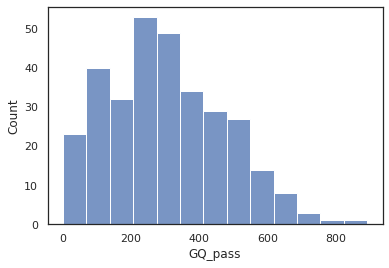

In [66]:
ID = "PD_0200"
ind_subset =df_meta_ID.loc[(df_meta_ID.PGDP_ID == ID) &
                           (df_meta_ID.chr == "chrX") &
                           (df_meta_ID.match_type != "nomatch")]
sns.histplot(ind_subset, x="GQ_pass")

In [67]:
ind_subset.sort_values(by=["lines"], ascending=False)

,lines,GQ_pass,ADFrac_pass,both_pass,PGDP_ID,species,match_type,chr,window,chrtype
2972,946,892,791,791,PD_0200,papAnu4,refmatch,chrX,86000000,chrX
2921,911,712,377,377,PD_0200,papAnu4,refmatch,chrX,35000000,chrX
2977,889,675,413,413,PD_0200,papAnu4,refmatch,chrX,91000000,chrX
2921,856,575,215,215,PD_0200,papAnu4,altmatch,chrX,35000000,chrX
2978,846,723,581,581,PD_0200,papAnu4,refmatch,chrX,92000000,chrX
...,...,...,...,...,...,...,...,...,...,...
2945,0,0,0,0,PD_0200,papAnu4,refmatch,chrX,59000000,chrX
2948,0,0,0,0,PD_0200,papAnu4,altmatch,chrX,62000000,chrX
2947,0,0,0,0,PD_0200,papAnu4,altmatch,chrX,61000000,chrX
2946,0,0,0,0,PD_0200,papAnu4,altmatch,chrX,60000000,chrX


In [68]:
IDs = sorted(df_meta_ID.PGDP_ID.unique())
x_a_ratio, x_het, aut_het = [], [], []

for ID in IDs:
    print(ID)
    df_s = df_meta_ID.loc[(df_meta_ID.PGDP_ID == ID) &
                          (df_meta_ID.match_type != "nomatch") &
                          (df_meta_ID.GQ_pass > 100)]
    aut = df_s.loc[(df_s.chrtype == "autosome")]
    a_het = aut.both_pass.mean()
    x = df_s.loc[(df_s.chr == "chrX") &
                              (df_s.window >= 2700000)]
    x_het.append(x.both_pass.mean())
    x_a_ratio.append((x.both_pass.mean())/a_het)
    aut_het.append(a_het)

PD_0001
PD_0003
PD_0004
PD_0005
PD_0006
PD_0007
PD_0008
PD_0010
PD_0011
PD_0012
PD_0013
PD_0014
PD_0015
PD_0016
PD_0017
PD_0018
PD_0019
PD_0020
PD_0021
PD_0022
PD_0023
PD_0024
PD_0025
PD_0026
PD_0027
PD_0028
PD_0029
PD_0030
PD_0031
PD_0032
PD_0033
PD_0034
PD_0035
PD_0036
PD_0037
PD_0038
PD_0039
PD_0040
PD_0041
PD_0042
PD_0043
PD_0044
PD_0045
PD_0046
PD_0047
PD_0048
PD_0049
PD_0050
PD_0051
PD_0052
PD_0053
PD_0054
PD_0055
PD_0056
PD_0057
PD_0058
PD_0059
PD_0060
PD_0061
PD_0062
PD_0063
PD_0064
PD_0065
PD_0066
PD_0068
PD_0069
PD_0070
PD_0071
PD_0072
PD_0073
PD_0074
PD_0075
PD_0076
PD_0077
PD_0078
PD_0079
PD_0080
PD_0081
PD_0082
PD_0083
PD_0084
PD_0085
PD_0086
PD_0087
PD_0088
PD_0089
PD_0090
PD_0091
PD_0092
PD_0093
PD_0094
PD_0095
PD_0096
PD_0097
PD_0098
PD_0099
PD_0100
PD_0101
PD_0102
PD_0103
PD_0104
PD_0105
PD_0106
PD_0107
PD_0108
PD_0109
PD_0110
PD_0111
PD_0114
PD_0115
PD_0116
PD_0117
PD_0118
PD_0119
PD_0120
PD_0121
PD_0122
PD_0123
PD_0124
PD_0125
PD_0126
PD_0127
PD_0128
PD_0129
PD_0130


In [69]:
meta_present = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)]
meta_present["x_a_ratio"] = x_a_ratio
meta_present["aut_het"] = aut_het
meta_present["x_het"] = x_het

/home/eriks/miniconda3/envs/primatediversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/eriks/miniconda3/envs/primatediversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/eriks/miniconda3/envs/primatediversity/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to

In [70]:
meta_present.GENUS = meta_present.GENUS.str.strip()

/home/eriks/miniconda3/envs/primatediversity/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [71]:
meta_present.to_csv("../steps/het_stats/meta_data_ratios_mean.txt")

<AxesSubplot:xlabel='aut_het', ylabel='x_het'>

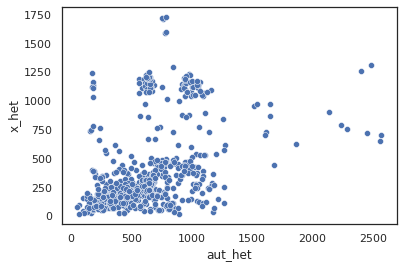

In [72]:
sns.scatterplot(data=meta_present, y="x_het", x="aut_het")

In [73]:
meta_present_f = meta_present.loc[meta_present.SEX == "F"]

<AxesSubplot:xlabel='aut_het', ylabel='x_a_ratio'>

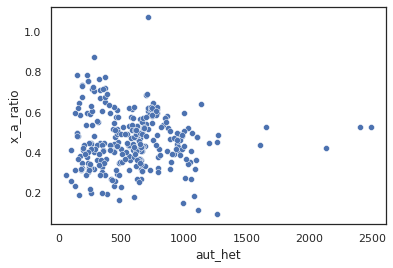

In [74]:
sns.scatterplot(data=meta_present_f, y="x_a_ratio", x="aut_het")

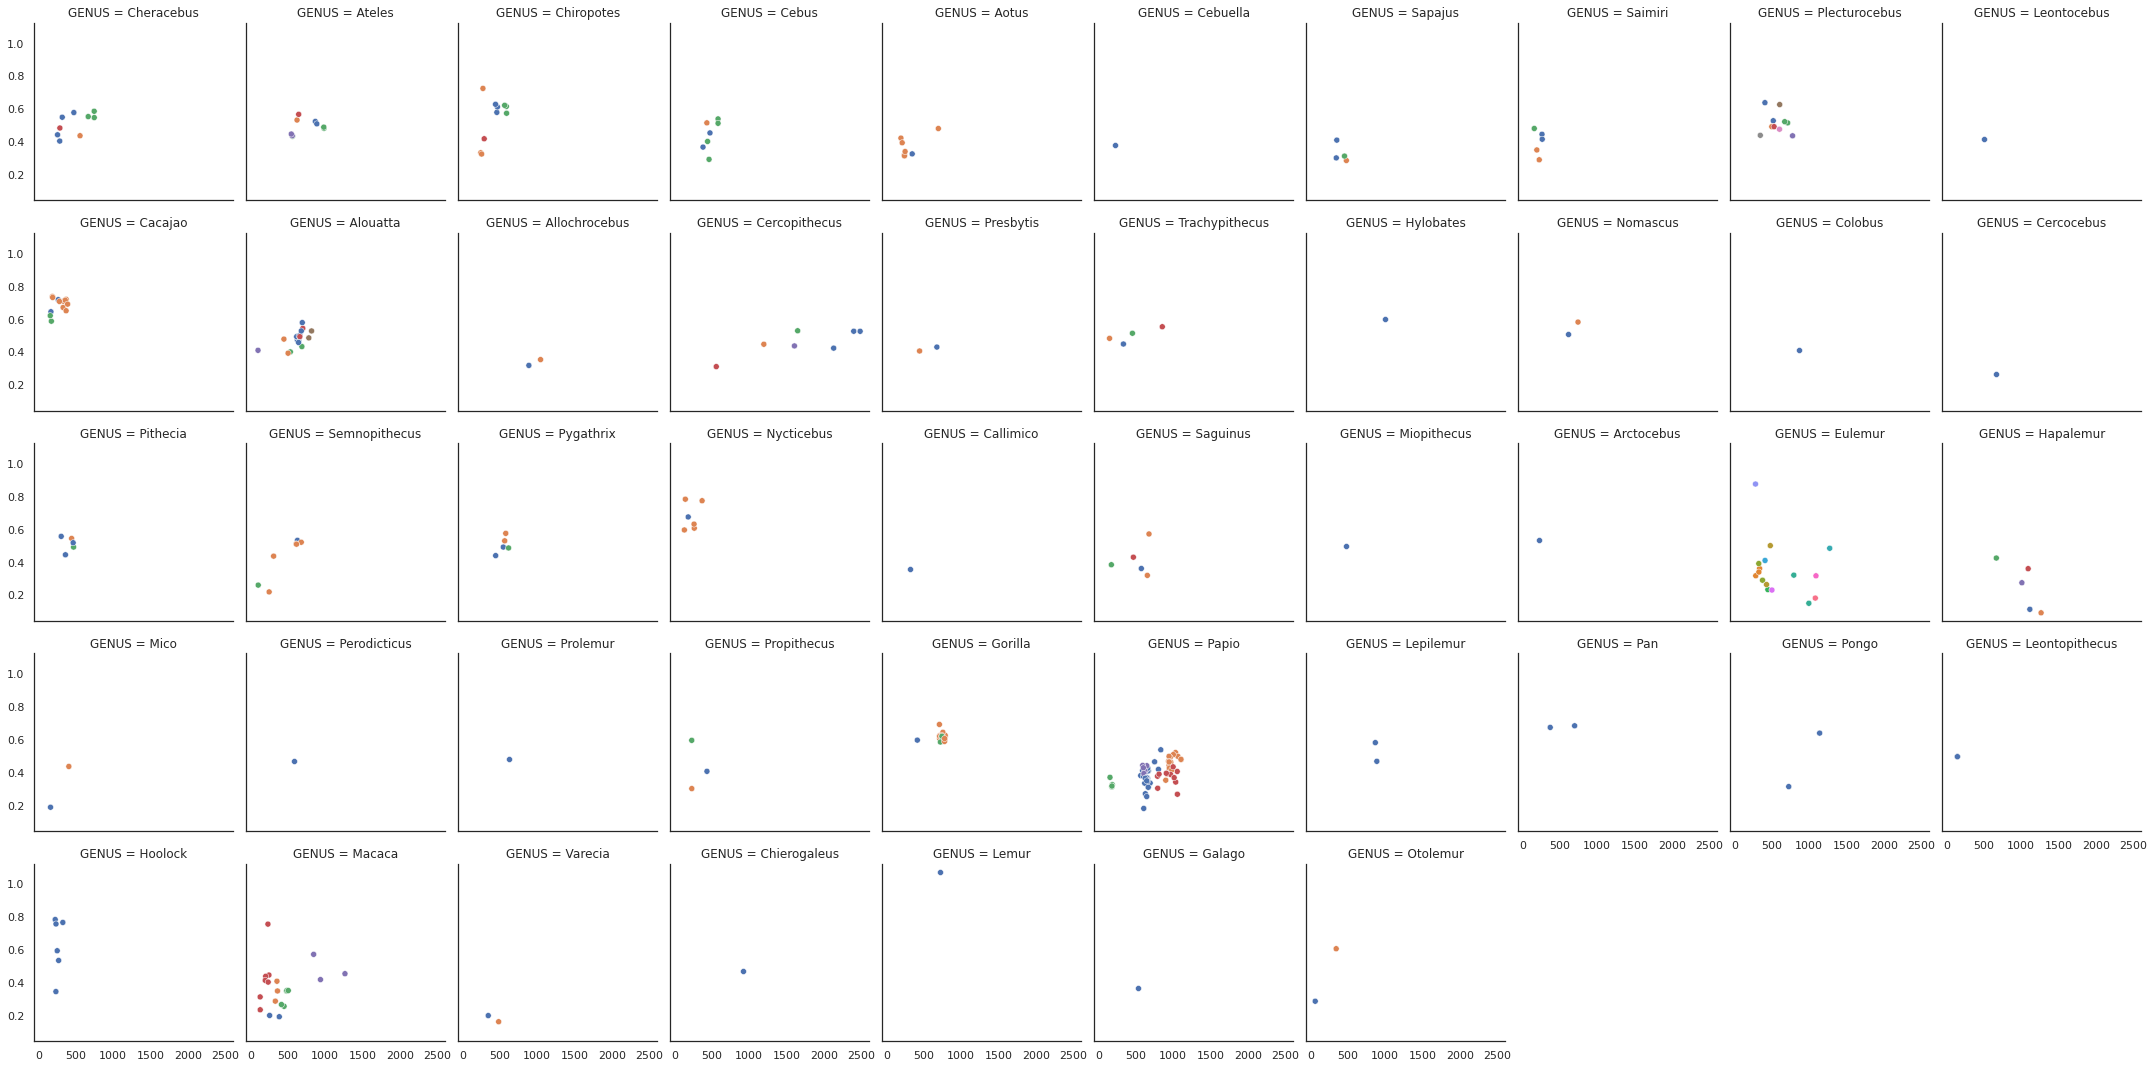

In [75]:
g = sns.FacetGrid(data=meta_present_f, col="GENUS", col_wrap = 10)
g.map_dataframe(sns.scatterplot, x="aut_het", y="x_a_ratio", hue="SPECIES")
#g.add_legend()

<AxesSubplot:xlabel='x_a_ratio', ylabel='Count'>

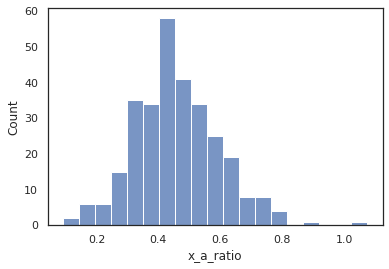

In [76]:
sns.histplot(meta_present_f, x="x_a_ratio", multiple="stack")

<AxesSubplot:xlabel='x_a_ratio', ylabel='Count'>

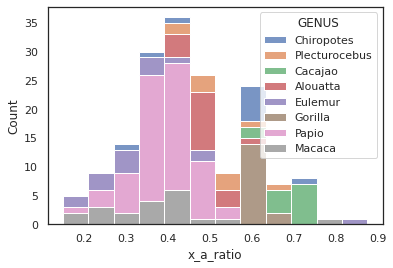

In [77]:
genus_pass = (meta_present_f.GENUS.value_counts() >= 10)
genus_pick = genus_pass.loc[genus_pass.values].index
sns.histplot(meta_present_f.loc[meta_present_f.GENUS.isin(genus_pick)], x="x_a_ratio", multiple="stack", hue="GENUS")

<AxesSubplot:xlabel='x_a_ratio', ylabel='Count'>

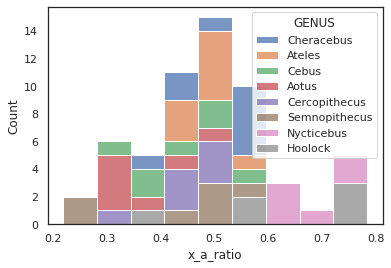

In [78]:
genus_pass = ((meta_present_f.GENUS.value_counts() > 5) & (meta_present_f.GENUS.value_counts() < 10))
genus_pick = genus_pass.loc[genus_pass.values].index
sns.histplot(meta_present_f.loc[meta_present_f.GENUS.isin(genus_pick)], x="x_a_ratio", multiple="stack", hue="GENUS")

<AxesSubplot:xlabel='x_a_ratio', ylabel='Count'>

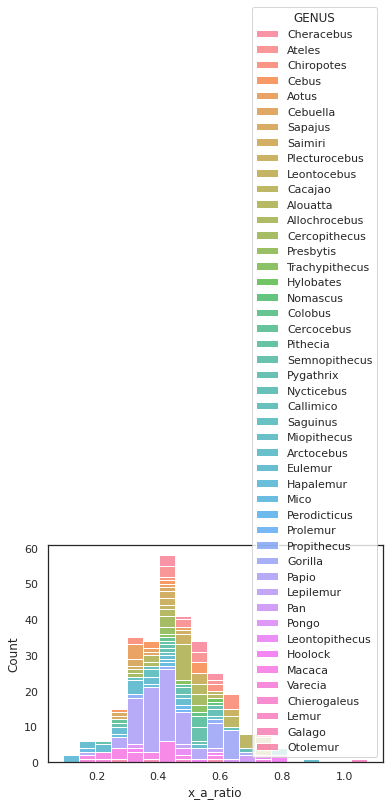

In [79]:
sns.histplot(meta_present_f, x="x_a_ratio", multiple="stack", hue="GENUS")

<AxesSubplot:xlabel='aut_het', ylabel='x_a_ratio'>

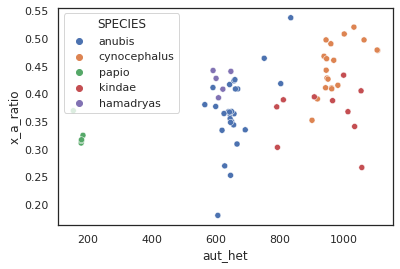

In [80]:
species_selection = "Papio"
s_df = meta_present_f.loc[meta_present_f.GENUS == species_selection]
sns.scatterplot(data=s_df, y="x_a_ratio", x="aut_het", hue="SPECIES")

Checking a bit up on some outliers

In [81]:
s_df.sort_values(by="x_a_ratio")

,PDGP_ID,GENUS,SPECIES,AB_QC,COV_QC,REFERENCE_SPECIES,REFERENCE_ASSEMBLY_ID,PGDP_ID,SEX,x_a_ratio,aut_het,x_het
220,PD_0222,Papio,anubis,PASS,PASS,Macaca_mulatta,rheMac10.fa,PD_0222,F,0.180384,606.107196,109.332046
588,PD_0737,Papio,anubis,PASS,PASS,Macaca_mulatta,rheMac10.fa,PD_0737,[F],0.252786,645.829218,163.256849
639,PD_0788,Papio,kindae,PASS,PASS,Macaca_mulatta,rheMac10.fa,PD_0788,[F],0.266903,1056.527544,281.989865
209,PD_0211,Papio,anubis,PASS,PASS,Macaca_mulatta,rheMac10.fa,PD_0211,F,0.269813,627.577378,169.328413
545,PD_0694,Papio,kindae,PASS,PASS,Macaca_mulatta,rheMac10.fa,PD_0694,[F],0.303303,792.545879,240.381757
...,...,...,...,...,...,...,...,...,...,...,...,...
212,PD_0214,Papio,cynocephalus,PASS,PASS,Macaca_mulatta,rheMac10.fa,PD_0214,F,0.497337,1063.481613,528.908784
224,PD_0226,Papio,cynocephalus,PASS,PASS,Macaca_mulatta,rheMac10.fa,PD_0226,F,0.497353,944.568521,469.783784
222,PD_0224,Papio,cynocephalus,PASS,PASS,Macaca_mulatta,rheMac10.fa,PD_0224,F,0.508066,1001.513276,508.834459
211,PD_0213,Papio,cynocephalus,PASS,PASS,Macaca_mulatta,rheMac10.fa,PD_0213,F,0.520428,1031.823705,536.989865


<AxesSubplot:xlabel='both_pass', ylabel='Count'>

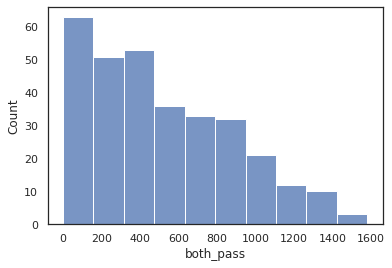

In [82]:
ID = "PD_0213"
ind_subset =df_meta_ID.loc[(df_meta_ID.PGDP_ID == ID) &
                           (df_meta_ID.chr == "chrX") &
                           (df_meta_ID.match_type != "nomatch")]
sns.histplot(ind_subset, x="both_pass")

In [83]:
ind_subset.both_pass.mean()

508.78662420382165

In [84]:
ind_subset

,lines,GQ_pass,ADFrac_pass,both_pass,PGDP_ID,species,match_type,chr,window,chrtype
2886,13,7,4,4,PD_0213,papAnu4,refmatch,chrX,0,chrX
2887,14,13,5,5,PD_0213,papAnu4,refmatch,chrX,1000000,chrX
2888,843,728,565,565,PD_0213,papAnu4,refmatch,chrX,2000000,chrX
2889,1355,1164,923,923,PD_0213,papAnu4,refmatch,chrX,3000000,chrX
2890,1794,1615,1305,1304,PD_0213,papAnu4,refmatch,chrX,4000000,chrX
...,...,...,...,...,...,...,...,...,...,...
3038,461,331,131,131,PD_0213,papAnu4,altmatch,chrX,152000000,chrX
3039,627,405,106,106,PD_0213,papAnu4,altmatch,chrX,153000000,chrX
3040,519,295,24,24,PD_0213,papAnu4,altmatch,chrX,154000000,chrX
3041,485,307,13,13,PD_0213,papAnu4,altmatch,chrX,155000000,chrX


Older code, used for the sex determination / investigation.

In [85]:
meta_data_samples.loc[(meta_data_samples.sex_lukas == "U")].PGDP_ID.values

AttributeError: 'DataFrame' object has no attribute 'sex_lukas'

In [ ]:
x_df = mb_df.loc[mb_df.chr == "chrX"]
y_df = mb_df.loc[mb_df.chr == "chrY"]
aut_df = mb_df.loc[(mb_df.chr != "chrX") & (mb_df.chr != "chrY")]

In [ ]:
x_u = x_df.loc[x_df.PGDP_ID.isin(meta_data_samples.loc[(meta_data_samples.sex_lukas == "U")].PGDP_ID.values)]
aut_u = aut_df.loc[aut_df.PGDP_ID.isin((meta_data_samples.loc[(meta_data_samples.sex_lukas == "U")].PGDP_ID.values))]

In [ ]:
x_u.groupby(["PGDP_ID"]).median().both_pass/aut_u.groupby(["PGDP_ID"]).median().both_pass

Most of these are clearly males or females - however, what is the gender of 168 and 169?
I will just set them as females, the horizonplot is mildly supportive of that.

In [ ]:
x_u.groupby(["PGDP_ID"]).median()

In [ ]:
x_u.groupby(["PGDP_ID"]).mean()

In [ ]:
sns.histplot(x_df.loc[x_df.window > 27000000].groupby(["PGDP_ID"]).median().lines/aut_df.groupby(["PGDP_ID"]).median().lines)

In [ ]:
sns.histplot(x_df.loc[x_df.window > 27000000].groupby(["PGDP_ID"]).median().both_pass/
             x_df.loc[x_df.window > 27000000].groupby(["PGDP_ID"]).median().lines)

In [ ]:
x_df.loc[x_df.window > 27000000].groupby(["PGDP_ID"]).median().both_pass/x_df.loc[x_df.window > 27000000].groupby(["PGDP_ID"]).median().lines

In [ ]:
sum(x_df.loc[x_df.window > 27000000].groupby(["PGDP_ID"]).median().both_pass/x_df.loc[x_df.window > 27000000].groupby(["PGDP_ID"]).median().lines < 0.01)

In [ ]:
sns.scatterplot(x=x_df.loc[x_df.window
                           > 27000000].groupby(["PGDP_ID"]).median().lines/aut_df.groupby(["PGDP_ID"]).median().lines,
               y=x_df.loc[x_df.window
                           < 27000000].groupby(["PGDP_ID"]).mean().both_pass/aut_df.groupby(["PGDP_ID"]).mean().both_pass)

In [ ]:
x_df.loc[x_df.window > 27000000].groupby(["PGDP_ID"]).median().lines/x_df.loc[x_df.window < 27000000].groupby(["PGDP_ID"]).median().lines

In [ ]:
sum(y_df.groupby(["PGDP_ID"]).median().lines < 1)

In [ ]:
from horizonplot import horizonplot

In [ ]:
x_df["start"] = x_df.window
x_df["chrom"] = x_df.chr

In [ ]:
#fig = horizonplot(x_df, 'lines', width=2, col='chr', row='PGDP_ID', size=0.3, aspect=100)

In [ ]:
fig = horizonplot(x_df, 'both_pass', width=2, col='chr', row='PGDP_ID', size=0.3, aspect=100)

In [ ]:
fig = horizonplot(x_df.loc[x_df.PGDP_ID.isin(meta_data_samples.loc[(meta_data_samples.sex_lukas == "U")].PGDP_ID.values)],
                           'both_pass', width=2, col='chr', row='PGDP_ID', size=0.3, aspect=100)

In [ ]:
sex_cov

Old Code/Comments

Short explanation of the logic path:
First, only gz files are read, to avoid readme and misc files.
Then, if the df exists (due to being stopped before finishing earlier), it checks whether this specific file has been analyzed. If it does, it will end on continue, and therefore skip it.
Then it goes to the actual analysis.
At the end, if the file does not exist, it is created.
Otherwise, a headerless row is added.

papio = ref_df.loc[ref_df.species == "papAnu4"]

papio.loc[papio.chr != "chrY"]
papio_autosomes = papio.loc[(papio.chr != "chrY") & (papio.chr != "chrX")]
papio_x = papio.loc[(papio.chr != "chrX")]

papio["chrtype"] = ["chrX" if x == "chrX" else "chrY" if x == "chrY" else "autosome" for x in papio["chr"]]

step_path = "../steps/het_stats/"
os.makedirs(step_path, exist_ok=True)

for name in files:
    if name.endswith(".gz"):
        name_elements = name.split(".")
        ind = name_elements[0]
        species = name_elements[1][:-10]
        match_type = name_elements[4]
        if os.path.isfile(step_path+"het_df.txt"):
            df_het = pd.read_csv(step_path+"het_df.txt")
            if len(df_het.loc[(df_het.PGDP_ID == ind) & (df_het.match_type == match_type)]) > 0:
                continue
        data = pd.read_csv(data_path+name,
                        compression="gzip", sep="\t", names=header_list)
        subset_list = []
        data_dict = {}
        subset_list.append((data.loc[(data.chr != "chrX") & (data.chr != "chrY")], "autosome"))
        subset_list.append((data.loc[(data.chr == "chrX") & (data.bp <= 2700000)], "PAR"))
        subset_list.append((data.loc[(data.chr == "chrX") & (data.bp > 2700000)], "nonPAR"))
        subset_list.append((data.loc[(data.chr == "chrY")], "chrY"))
        data_dict["PGDP_ID"], data_dict["species"], data_dict["match_type"] = ind, species, match_type
        for subset, n in subset_list:
            data_dict["lines_"+n] = len(subset)
            data_dict["GQ_"+n] = len(subset.loc[subset.GQ == 99])
            data_dict["ADFrac_"+n] = len(subset.loc[(subset.ADFrac < 0.7) & (subset.ADFrac > 0.3)])
            data_dict["both_"+n] = len(subset.loc[(subset.ADFrac < 0.7) & (subset.ADFrac > 0.3) & (subset.GQ == 99)])
        df = pd.DataFrame(data_dict, index=[0])
        if not os.path.isfile(step_path+"het_df.txt"):
            df.to_csv(step_path+"het_df.txt", index=False)
        else:
            with open(step_path+"het_df.txt", "a") as f:
                df.to_csv(f, header=False, index=False)
        del data
        del subset_list
        gc.collect()
    print(name)

pd.read_csv(step_path+"het_df.txt")